In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import h5py
import numpy.ma as ma
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#Opening h5 data file, reading data into arrays, then closing file
file_name = '20110518.001_lp_5min-cal.h5'
hf = h5py.File(file_name, 'r')

altitude = np.array(hf['NeFromPower/Altitude'])
Ne_NoTr = np.array(hf['NeFromPower/Ne_NoTr'])
dtime = np.array(hf['Time/dtime'])

hf.close()

#Printing shape of arrays
print 'Altiude Shape: ', altitude.shape
print 'Ne_NoTr Shape: ', Ne_NoTr.shape
print 'dtime Shape: ', dtime.shape

Altiude Shape:  (4, 180)
Ne_NoTr Shape:  (511, 4, 180)
dtime Shape:  (511, 2)


In [4]:
Ne_NoTr_0 = np.array(Ne_NoTr[110:294,0,36:126])
Ne_reg_sampled_array = np.zeros((184,90))
Ne_filtered_array = np.zeros((184,90))


#Adding 24 to  all values in time array after UT resets to zero
dtime_shift = np.copy(dtime[110:294,:])
dtime_shift[160,1] += 24
dtime_shift[161:,:]+= 24
#Creating mean time array
dtime_shift_mean = np.mean(dtime_shift,axis=1)

#Define functions used to filter data
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs                    #Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

#Define time array w/ spacing similar to original time sampling
t = np.linspace(dtime_shift_mean[0],dtime_shift_mean[-1],int(dtime_shift_mean.size))

# Filter requirements.
order = 6
sampling_period_hr = t[1] - t[0]
fs = float(1) / float(sampling_period_hr) # sampling frequency, Hz
cutoff = float(1) / float(2) # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

index_range = Ne_NoTr_0.shape[1]

for i in range(index_range):
    Ne_alt_bin = Ne_NoTr_0[:,i] # 1-D Ne array for altitude 0 and pole 0
    Ne_alt_bin_m1 = ma.masked_less_equal(Ne_alt_bin,0) # masking negative electron densities
    Ne_alt_bin_m2 = np.ma.masked_invalid(Ne_alt_bin_m1) # masking NaN values
    #Matrix of indexes for nonzero (i.e. nonmasked) elements in Ne array
    Ne_index = ma.nonzero(Ne_alt_bin_m2)
    if len(Ne_index[0]) > 1:
        time_mask_removed = np.copy(dtime_shift_mean)
        # Setting masked values in time array to 0
        for j in range(159):
            if np.isin(j,Ne_index) == False:
                time_mask_removed[j] = 0
        # Removing zero values from time array   
        time_interp = time_mask_removed[np.nonzero(time_mask_removed)] 
        # Removing masked values from Ne array
        Ne_for_interp = ma.compressed(Ne_alt_bin_m2) 
        # Defining interpolation function for Ne (as function of time)
        interp_fun_Ne = interp1d(time_interp, Ne_for_interp,kind='cubic')
        #Setting up Ne arry
        t1 = time_interp[0]
        t2 = time_interp[-1]
        Ne_reg_sampled = np.piecewise(t, [t < t1, (t1 <= t) & (t <= t2), t > t2], [0, lambda t: interp_fun_Ne(t) , 0])
        #Filter data passed through filtfilt to get response curve
        Ne_filtered = filtfilt(b,a,Ne_reg_sampled)
    else:
        Ne_reg_sampled = np.zeros(159)
        Ne_filtered = np.zeros(159)
    Ne_reg_sampled_array[:,i] = Ne_reg_sampled 
    Ne_filtered_array[:,i] = Ne_filtered

In [6]:
rel_e_densities = (Ne_reg_sampled_array - Ne_filtered_array) / Ne_filtered_array

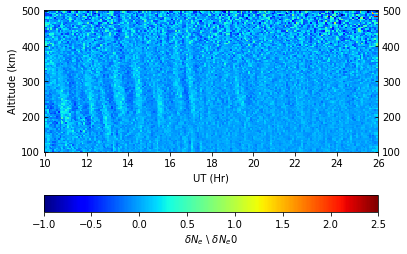

In [7]:
altitude_0 = np.array(altitude[0,36:126])
altitude_0_km = altitude_0 / 1000
ymin, ymax = altitude_0_km[0], altitude_0_km[-1]
yi = np.linspace(ymin,ymax,Ne_NoTr_0.shape[1])
Y, X = np.meshgrid(yi,t)
Z = rel_e_densities
fig, ax = plt.subplots()
im = ax.pcolormesh(X,Y,Z, norm = colors.Normalize(vmin = -1, vmax=2.5), cmap = plt.get_cmap('jet'))
ax.tick_params(axis = 'y',right=True, labelright=True, direction='in')
#lbs = ['','16','18','20','22','00','02']
#ax.set_xticklabels(lbs)
cbar = fig.colorbar(im, orientation = "horizontal", pad = .20)
cbar.set_label('$\delta N_e$ \ $\delta N_e0$')
#plt.title('Electron Densities')
plt.xlabel('UT (Hr)')
plt.ylabel('Altitude (km)')
plt.savefig('relative_e_den_Negale.png')

In [13]:
from astropy.stats import LombScargle

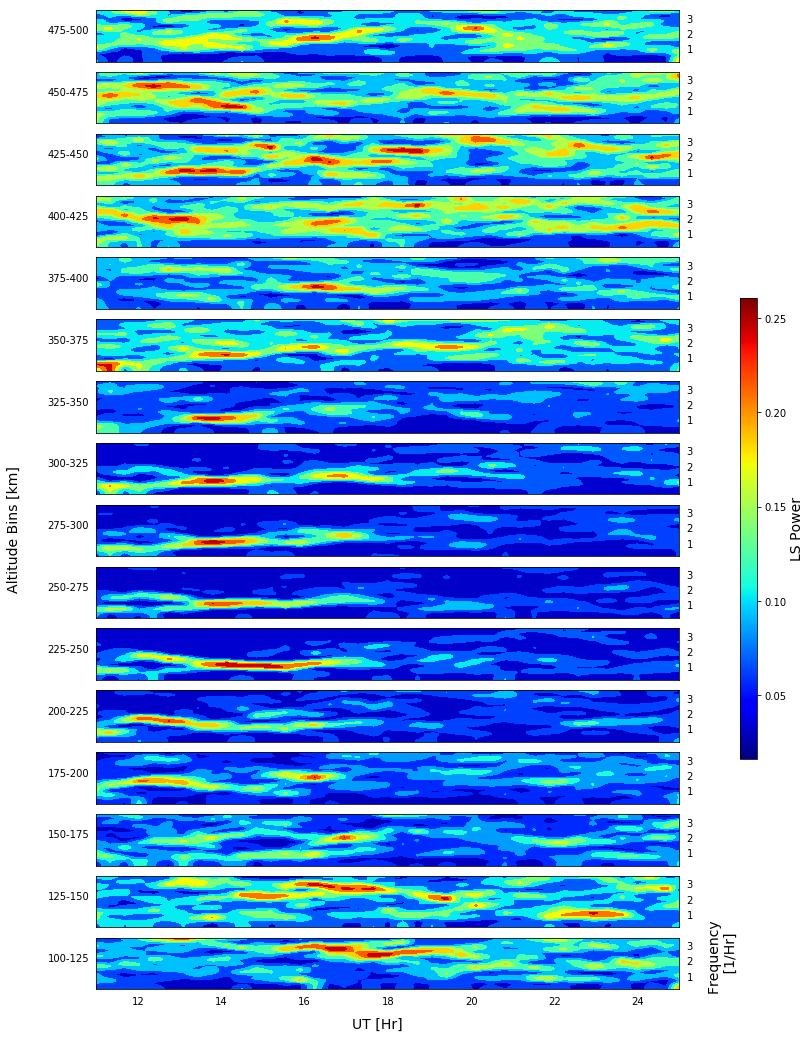

In [184]:
fig_size = ['','']
fig_size[0] = 12
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size
fig, axes = plt.subplots(16, 1, sharex=True)
subplt_num = 15


freq_len = 100
frequency = np.linspace(.1,3.5,freq_len)
t_power = np.zeros(41)
dx = t_power[1] - t_power[0]
dy = frequency[1] - frequency[0]
alt_num = 0
#---------------
for alt_bin in range(125,525,25):
    avg_spec = np.zeros((41,freq_len))
    norm = 0
    while(altitude_0_km[alt_num] < float(alt_bin)):
        ti = 0
        power_spec = np.zeros((41,freq_len))
        for k in range(0,(len(t)-23),4):
            Ne_rel_bin = rel_e_densities[k:23+k,alt_num]
            t_sample = t[k:23+k]
            t_power[ti] = t_sample[12]
            power_spec[ti,:] = LombScargle(t_sample,Ne_rel_bin).power(frequency)
            ti += 1
        avg_spec += power_spec
        alt_num += 1
        norm += 1
    avg_spec = (avg_spec / float(norm))
    Yspec,Xspec = np.meshgrid(frequency,t_power)
    # Plotting averaged spectrogram subplot for subplot
    axes[subplt_num].contourf(Xspec + (dx/2.),Yspec + (dy/2.),avg_spec, cmap=cmap)
    y_subplot_str = str(alt_bin-25)+'-'+str(alt_bin)
    axes[subplt_num].set_ylabel(y_subplot_str,rotation=0,labelpad=28)
    axes[subplt_num].tick_params(
        axis = 'y',
        left=False,
        right=False,
        labelleft=False,
        labelright=True)
    axes[subplt_num].tick_params(
        axis = 'x',
        bottom=False)
    axes[subplt_num].set_xlim([11, 25])
    # Want to plot from bottom to top    
    subplt_num -= 1
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.95)
cax1 = fig.add_axes([0.87,0.3,0.02,0.4])
cbar = plt.colorbar(im,cax=cax1,orientation='vertical')
cbar.set_label('LS Power',fontsize=14)
fig.text(0.45, 0.07, 'UT [Hr]', ha='center', va='center', fontsize = 14)
fig.text(0.03, 0.5, 'Altitude Bins [km]', ha='center', va='center', rotation='vertical',fontsize = 14)
fig.text(0.85, 0.13,'Frequency \n [1/Hr]', ha='center', va='center', rotation='vertical',fontsize = 14)
fig.savefig('Spectrogram_MSTID')